In [2]:
import numpy as np

def compute_ks_metric(X_test, model, target_column_names, n_traces, future_length):
    """
    Computes the KS metric for a given model and test dataset.

    Parameters:
    - X_test: DataFrame containing ground truth values.
    - model: A model that predicts a categorical distribution over a discretization of the ground truth variable.
    - target_column_names: List of target column names in X_test.
    - n_traces: Number of traces (samples) to generate for each prediction.
    - future_length: Number of future time steps to predict.

    Returns:
    - kss: Array containing the KS metrics for each target and horizon.
    """
    n_samples = len(X_test)
    kss = np.zeros((len(target_column_names), future_length))

    for horizon in range(future_length):
        print(f"Predict horizon {horizon}/{future_length}")

        # Generate predictions for the current horizon
        observations = model.predict(X_test.iloc[:horizon])  # Assuming model.predict takes past observations
        observations = observations.reshape(n_samples, n_traces, -1)

        for t_i, target_name in enumerate(target_column_names):
            traces = observations[:, :, t_i]
            ground_truth = X_test[target_name].iloc[horizon].to_numpy()

            # Compute quantiles
            quantiles = np.sort(np.array([g > m for g, m in zip(ground_truth, traces)]).sum(axis=1))
            quantiles = quantiles / n_traces

            # Compute KS metric
            kss[t_i, horizon] = np.max(np.abs(quantiles - (np.arange(len(quantiles)) / len(quantiles))))

    return kss

# Example usage:
# kss = compute_ks_metric(X_test, model, target_column_names, n_traces, future_length)


array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0])

# Halfcheetah

In [2]:
# run this when you first launch the notebook
%cd ../benchmark/halfcheetah_raw

C:\Users\awx1116470\Work\rl_simulator\benchmark\halfcheetah_raw


In [116]:
# run this after running on hopper
%cd ../halfcheetah_raw

C:\Users\awx1116470\Work\rl_simulator\benchmark\halfcheetah_raw


## ablation study

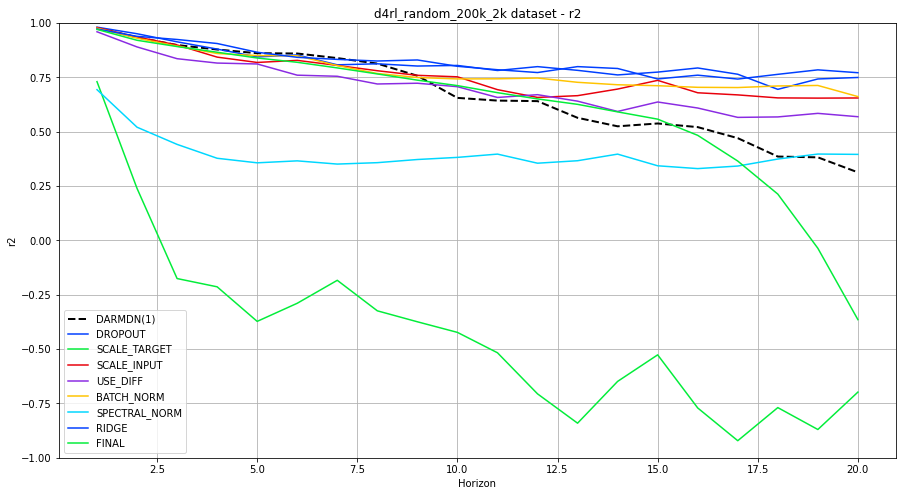

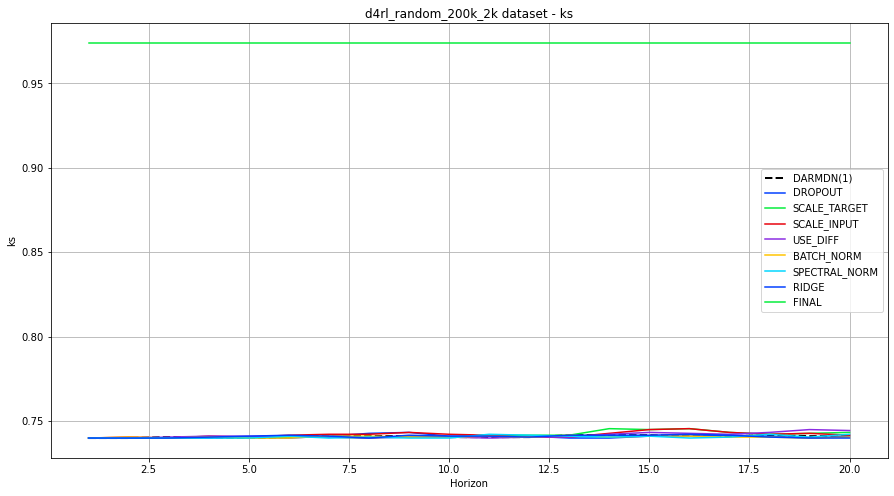

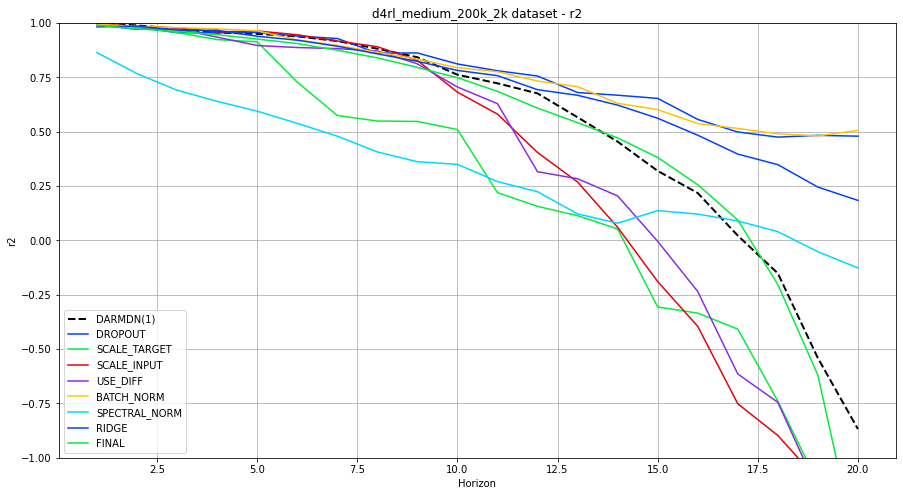

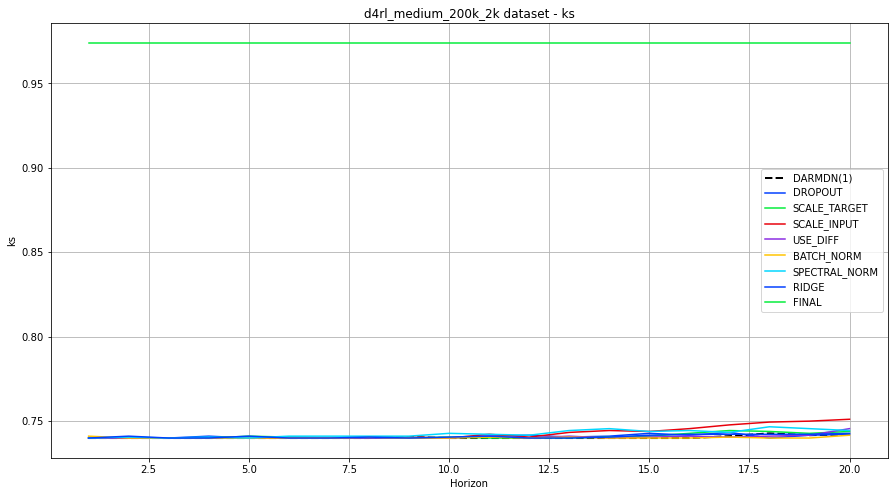

In [76]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-bright')
import pandas as pd
import numpy as np

future_length = 6

data_labels = ['d4rl_random_200k_2k', 'd4rl_medium_200k_2k']
n_folds = 1
    
submissions_and_labels = [
    ('darmdn_single', 'DARMDN(1)'),
    ('darmdn_single_dropout', 'DROPOUT'),
    ('darmdn_single_scale_target', 'SCALE_TARGET'),
    ('darmdn_single_scale_input', 'SCALE_INPUT'),
    ('darmdn_single_use_diff', 'USE_DIFF'),
    ('darmdn_single_batch_norm', 'BATCH_NORM'),
    ('darmdn_single_spectral_norm', 'SPECTRAL_NORM'),
    ('darmdn_single_ridge', 'RIDGE'),
    ('darmdn_single_final', 'FINAL')
]

metrics = ['r2', 'ks']
for data_label in data_labels:
    for i, metric in enumerate(metrics):
        fig, axes = plt.subplots(1, figsize=(15, 8))

        for submission, label in submissions_and_labels:
            # future_board = future_leaderboard(submission, data_label, n_folds, future_length)
            file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'future_leaderboard_df.csv')
            future_board = pd.read_csv(file_path)
            score_means = [future_board[metric+'_mean']]
            score_stds = [future_board[metric+'_std']]
            score_names = [metric]
            axis = np.arange(1, len(score_means[0]) + 1)

            for config in zip([axes], score_means, score_stds, score_names):
                ax, score_mean, score_std, score_name = config
                if submission == 'darmdn_single':
                    ax.plot(axis, score_mean, 'k--', label=label, linewidth=2)
                else:
                    ax.plot(axis, score_mean, label=label)
                ax.set_ylabel(score_name)
                # ax.set_xticks(axis)
                ax.fill_between(
                    axis,
                    score_mean - 1.645 * score_std / np.sqrt(n_folds),
                    score_mean + 1.645 * score_std / np.sqrt(n_folds),
                    alpha=0.1)
                ax.legend(loc=0)
        if metric == 'r2':
            ax.set_ylim(-1, 1)
        ax.grid()

        plt.xlabel('Horizon')
        plt.title(f'{data_label} dataset - {metric}')
plt.show()

## all in one

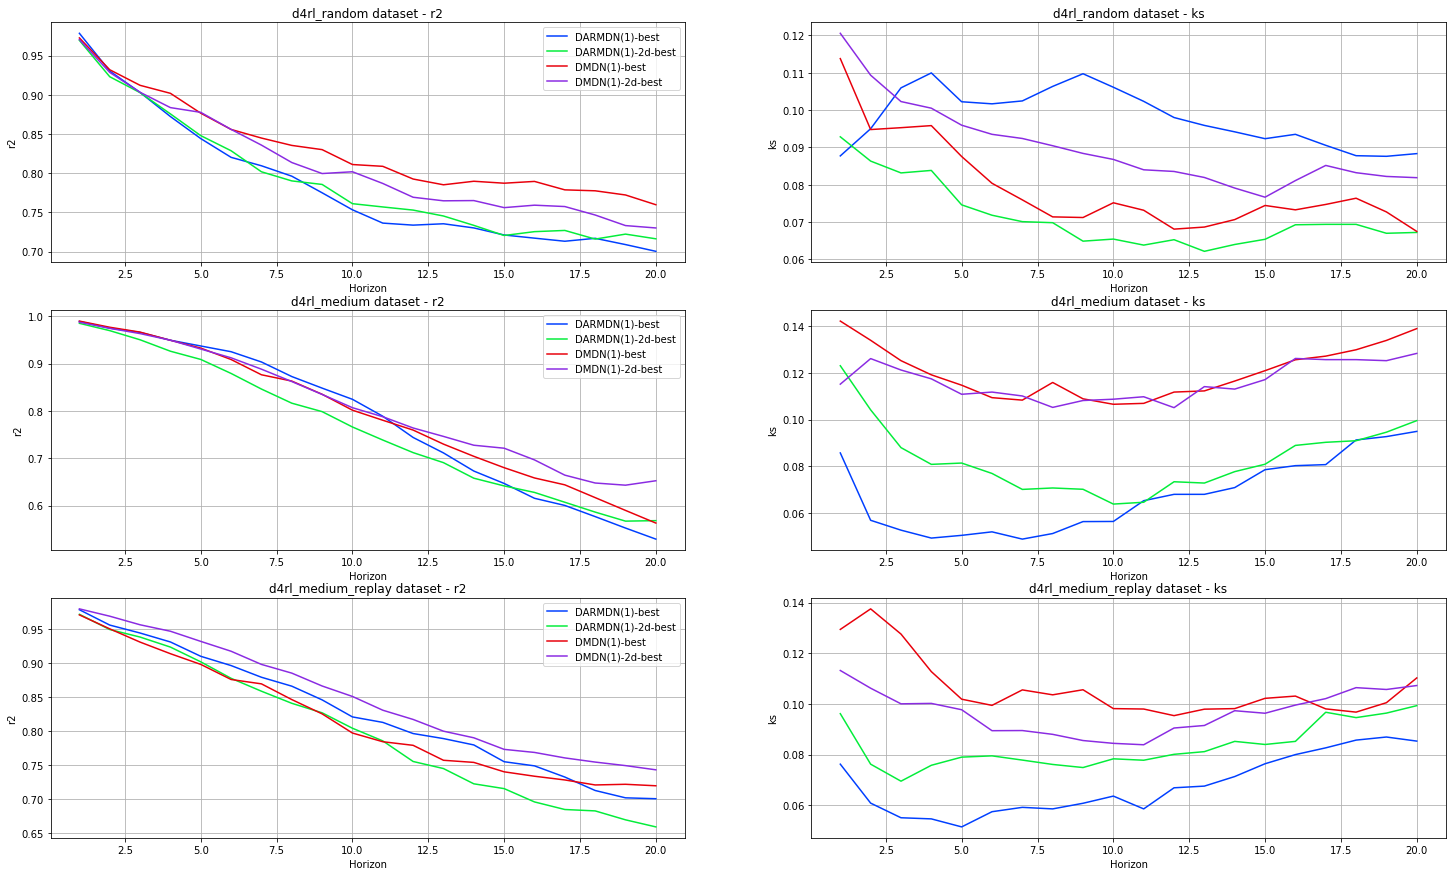

In [117]:
future_length = 20

data_labels = ['d4rl_random', 'd4rl_medium', 'd4rl_medium_replay']
n_folds = 1
    
submissions_and_labels = [
    ('darmdn_single_1m_200', 'DARMDN(1)-best'),
    ('darmdn_single_1m_100', 'DARMDN(1)-2d-best'),
    ('dmdn_single_1m_leakyrelu_3', 'DMDN(1)-best'),
    ('dmdn_single_1m_tanh_2', 'DMDN(1)-2d-best'),
    # ('dmdn_single_ensemble_vectorized', 'DMDN(1)-ens')
    ]

metrics = ['r2', 'ks']
fig=plt.figure(figsize=(25,15))
        
for idx_data, data_label in enumerate(data_labels):
    for i, metric in enumerate(metrics):
        axes = fig.add_subplot(3,2,2*idx_data+i+1)

        for submission, label in submissions_and_labels:
            # future_board = future_leaderboard(submission, data_label, n_folds, future_length)
            file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'future_leaderboard_df.csv')
            future_board = pd.read_csv(file_path)
            score_means = [future_board[metric+'_mean']]
            score_stds = [future_board[metric+'_std']]
            score_names = [metric]
            axis = np.arange(1, len(score_means[0]) + 1)

            for config in zip([axes], score_means, score_stds, score_names):
                ax, score_mean, score_std, score_name = config
                ax.plot(axis, score_mean, label=label)
                ax.set_ylabel(score_name)

        if metric == 'r2':
            ax.legend(loc=0)
        ax.grid()

        plt.xlabel('Horizon')
        plt.title(f'{data_label} dataset - {metric}')
plt.show()

# Hopper

In [3]:
%cd ../hopper_raw

C:\Users\awx1116470\Work\rl_simulator\benchmark\hopper_raw


## all in one

FileNotFoundError: [Errno 2] No such file or directory: 'submissions\\darmdn_single_d4rl_medium_expert_50k_500k_hyperopt\\training_output\\d4rl_medium_expert\\fold_0\\long_horizon_metrics\\future_leaderboard_df.csv'

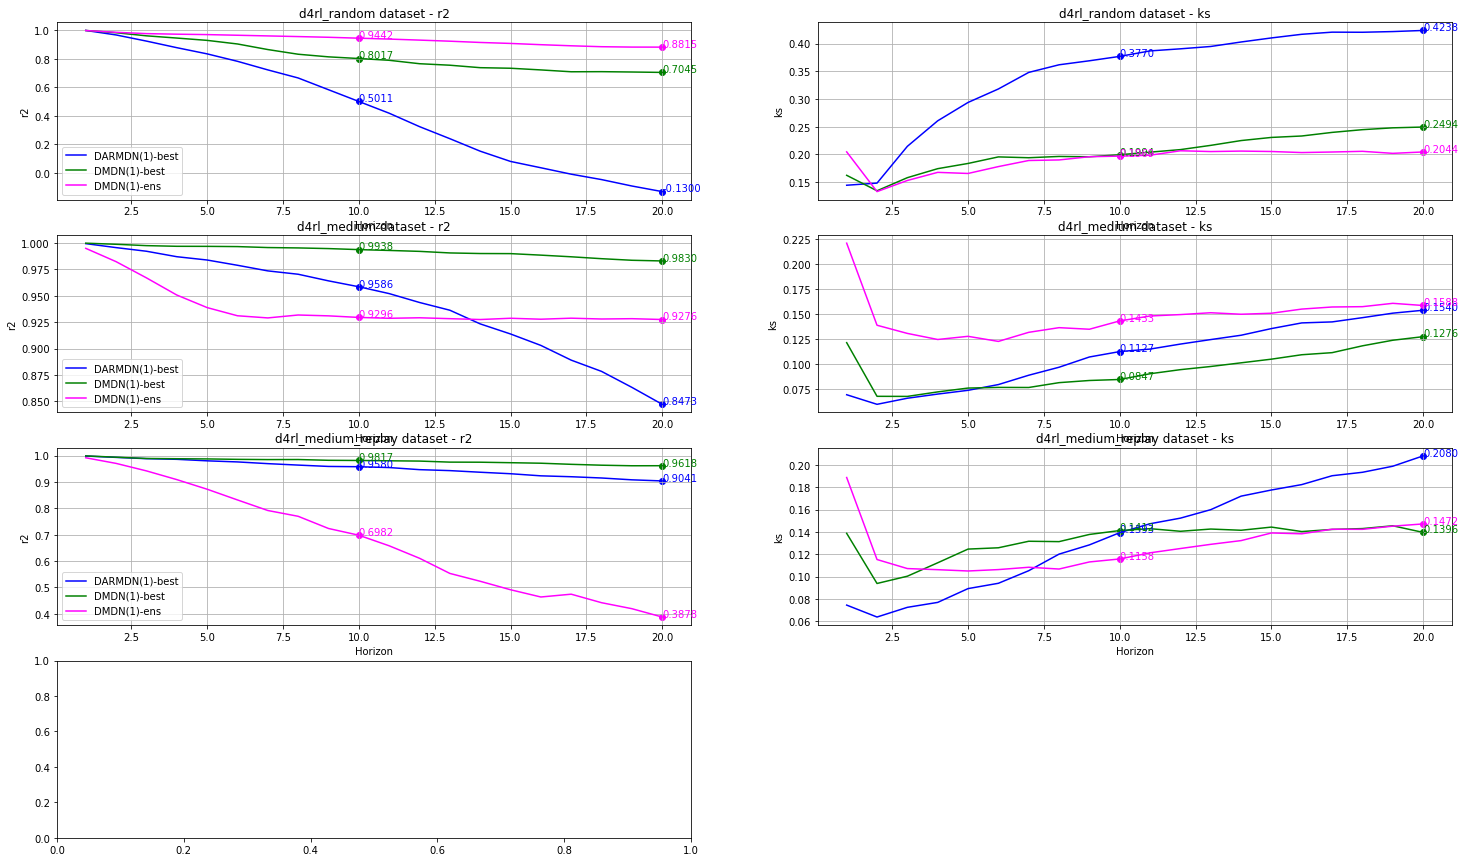

In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-bright')
import pandas as pd
import numpy as np

data_labels = ['d4rl_random', 'd4rl_medium', 'd4rl_medium_replay', 'd4rl_medium_expert']
n_folds = 1
    
submissions_and_labels_dict = {'d4rl_random': [
    ('darmdn_single_d4rl_random_50k_500k_hyperopt', 'DARMDN(1)-best'),
    # ('darmdn_single_d4rl_random_50k_500k_hyperopt_1', 'DARMDN(1)-2d-best'),
    ('dmdn_single_d4rl_random_50k_500k_hyperopt', 'DMDN(1)-best'),
    # ('dmdn_single_d4rl_random_50k_500k_hyperopt_1', 'DMDN(1)-2d-best'),
    ('dmdn_single_ensemble_vectorized', 'DMDN(1)-ens')],
                               'd4rl_medium': [
    ('darmdn_single_d4rl_medium_50k_500k_hyperopt', 'DARMDN(1)-best'),
    ('dmdn_single_d4rl_medium_50k_500k_hyperopt', 'DMDN(1)-best'),
    ('dmdn_single_ensemble_vectorized', 'DMDN(1)-ens')],
                               'd4rl_medium_replay': [
    ('darmdn_single_d4rl_medium_replay_hyperopt', 'DARMDN(1)-best'),
    ('dmdn_single_d4rl_medium_replay_hyperopt', 'DMDN(1)-best'),
    ('dmdn_single_ensemble_vectorized', 'DMDN(1)-ens')],
                               'd4rl_medium_expert': [
    ('darmdn_single_d4rl_medium_expert_50k_500k_hyperopt', 'DARMDN(1)-best'),
    ('dmdn_single_ensemble_vectorized', 'DMDN(1)-ens')],
}

colors = ['blue', 'green', 'fuchsia']

metrics = ['r2', 'ks']
fig=plt.figure(figsize=(25,15))

for idx_data, data_label in enumerate(data_labels):
    for i, metric in enumerate(metrics):
        axes = fig.add_subplot(4,2,2*idx_data+i+1)

        for i, (submission, label) in enumerate(submissions_and_labels_dict[data_label]):
            # future_board = future_leaderboard(submission, data_label, n_folds, future_length)
            file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'future_leaderboard_df.csv')
            future_board = pd.read_csv(file_path)
            score_means = [future_board[metric+'_mean']]
            score_stds = [future_board[metric+'_std']]
            score_names = [metric]
            axis = np.arange(1, len(score_means[0]) + 1)

            for config in zip([axes], score_means, score_stds, score_names):
                ax, score_mean, score_std, score_name = config
                ax.plot(axis, score_mean, label=label, color=colors[i])
                ax.set_ylabel(score_name)
                
                # metric(10)
                txt = f"{score_mean[9]:.4f}"
                ax.annotate(txt, (axis[9], score_mean[9]), color=colors[i])
                ax.scatter(axis[9], score_mean[9], color=colors[i])
                
                # metric(20)
                txt = f"{score_mean[19]:.4f}"
                ax.annotate(txt, (axis[19], score_mean[19]), color=colors[i])
                ax.scatter(axis[19], score_mean[19], color=colors[i])

        if metric == 'r2':
            ax.legend(loc=0)
        ax.grid()

        plt.xlabel('Horizon')
        plt.title(f'{data_label} dataset - {metric}')
plt.show()

## KS plot

In [58]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-bright')
import pandas as pd
import numpy as np
from scipy.stats import uniform
from scipy.special import kolmogorov
from scipy.stats import kstwobign

def ks_cdf(env='hopper-v2', data_label='d4rl_random', n_traces=25, submission='darmdn_single_d4rl_random_50k_500k_hyperopt', feature='rootz', horizon=1, verbose=0):
    
    file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'ks_quantiles_df.csv')
    ks_quantiles = pd.read_csv(file_path)

    quantiles = ks_quantiles[feature].to_numpy().flatten()
    quantiles = quantiles.reshape((FUTURE_LENGTH, N_SAMPLES))[horizon-1, :]

    x = quantiles
    n = len(quantiles)

    target = uniform(loc=0, scale=np.max(x))  # Uniform over [0, 1]
    cdfs = target.cdf(x)
    ecdfs = np.arange(n+1, dtype=float)/n
    gaps = np.column_stack([cdfs - ecdfs[:n], ecdfs[1:] - cdfs])
    
    if verbose:
        Dn = np.max(gaps)
        Kn = np.sqrt(n) * Dn
        print('Dn=%f, sqrt(n)*Dn=%f' % (Dn, Kn))
        print(chr(10).join(['For a sample of size n drawn from a uniform distribution:',
          ' the approximate Kolmogorov probability that sqrt(n)*Dn>=%f is %f' %  (Kn, kolmogorov(Kn)),
          ' the approximate Kolmogorov probability that sqrt(n)*Dn<=%f is %f' %  (Kn, kstwobign.cdf(Kn))]))

    fig = plt.figure(1, figsize=(8, 8))

    plt.step(np.concatenate([[0], x]), ecdfs, where='post', label='Empirical CDF')

    plt.plot(x, cdfs, label='CDF for Uniform')
    plt.ylim([0, 1]); plt.grid(True); plt.legend();

    # Add vertical lines marking Dn+ and Dn-
    iminus, iplus = np.argmax(gaps, axis=0)
    plt.vlines([x[iminus]], ecdfs[iminus], cdfs[iminus], color='r', linestyle='dashed', lw=4)
    plt.vlines([x[iplus]], cdfs[iplus], ecdfs[iplus+1], color='r', linestyle='dashed', lw=4)

    plt.title(f"KS plot: feature '{feature}' - env '{env}' - submission '{submission}' - data_label '{data_label}' - n_traces '{n_traces}'")
    plt.xlabel("Quantiles")
    plt.ylabel("CDF")

    plt.show()

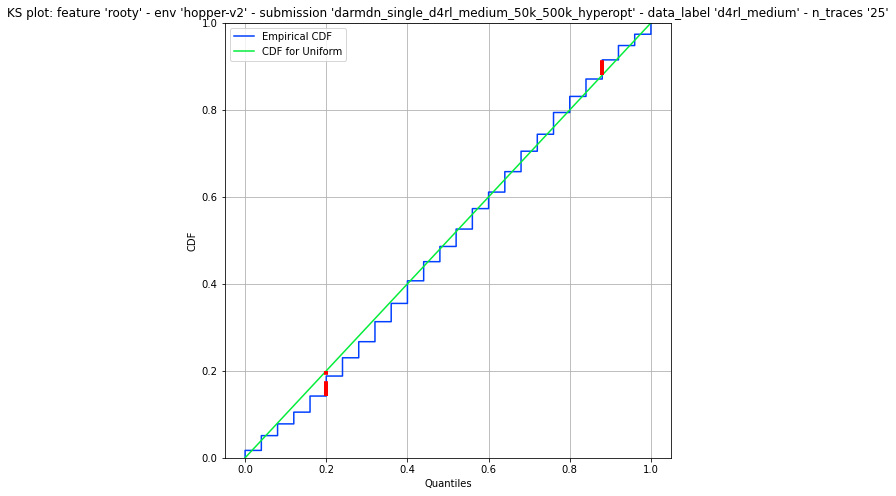

In [59]:
FUTURE_LENGTH = 20
N_SAMPLES = 1000

env = 'hopper-v2'

data_label = 'd4rl_medium'
n_traces = 25

submission = 'darmdn_single_d4rl_medium_50k_500k_hyperopt'
feature = 'rooty'

horizon = 1

ks_cdf(env=env, data_label=data_label, n_traces=n_traces, submission=submission, feature=feature, horizon=horizon)

In [60]:
from mbrltools.data_processing import get_metadata_dictionary

def ks_cdf_all(env='hopper-v2', data_label='d4rl_random', n_traces=25, submission='darmdn_single_d4rl_random_50k_500k_hyperopt', horizon=1, label='no_label', verbose=0):
    
    file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'ks_quantiles_df.csv')
    ks_quantiles = pd.read_csv(file_path)
    print(f"ks_quantiles shape: {ks_quantiles.shape}")

    # metadata
    metadata_path = os.path.join('data', 'metadata.json')
    metadata = get_metadata_dictionary(metadata_path)

    n_dim = 12
    n_bins = n_traces

    #Visualize results
    fig=plt.figure(figsize=(25,15))
    for i in range(12):
        a=fig.add_subplot(3,4,i+1)

        feature = metadata['observation'][i] 
        quantiles = ks_quantiles[feature].to_numpy().flatten()
        quantiles = quantiles.reshape((FUTURE_LENGTH, N_SAMPLES))[horizon-1, :]
        x = quantiles
        n = len(quantiles)

        a.set_title(feature)
        # plt.xlabel('quantiles')
        # plt.ylabel('count')

        plt.hist(x, bins=n_bins)
        plt.hlines(n/n_bins, 0, 1, color='r', linestyle='dashed', lw=1)

    fig.suptitle(f'{label}: Error quantiles histogram per observation dimension - horizon {horizon}', fontsize=26)

    fig=plt.figure(figsize=(25,15))
    for i in range(12):
        a=fig.add_subplot(3,4,i+1)

        feature = metadata['observation'][i] 
        quantiles = ks_quantiles[feature].to_numpy().flatten()
        quantiles = quantiles.reshape((FUTURE_LENGTH, N_SAMPLES))[horizon-1, :]
        x = quantiles

        a.set_title(feature)

        target = uniform(loc=0, scale=np.max(x))  # Uniform over [0, 1]
        cdfs = target.cdf(x)
        ecdfs = np.arange(n+1, dtype=float)/n
        gaps = np.abs(np.column_stack([cdfs - ecdfs[:n], ecdfs[1:] - cdfs])).max(axis=1)

        plt.step(np.concatenate([[0], x]), ecdfs, where='post', label='Empirical CDF')

        plt.plot(np.concatenate([[0], x]), np.concatenate([[0], cdfs]), label='CDF for Uniform')
        plt.ylim([0, 1]); plt.grid(True); plt.legend();

        # Add vertical lines marking Dn+ and Dn-
        imax = np.argmax(gaps, axis=0)
        plt.vlines([x[imax]], ecdfs[imax], cdfs[imax], color='r', linestyle='dashed', lw=4)

        plt.xlabel("Quantiles")
        plt.ylabel("CDF")

    fig.suptitle(f'{label}: Error quantiles CDF per observation dimension + KS statistic - horizon {horizon}', fontsize=26)
    plt.show()

ks_quantiles shape: (20000, 12)


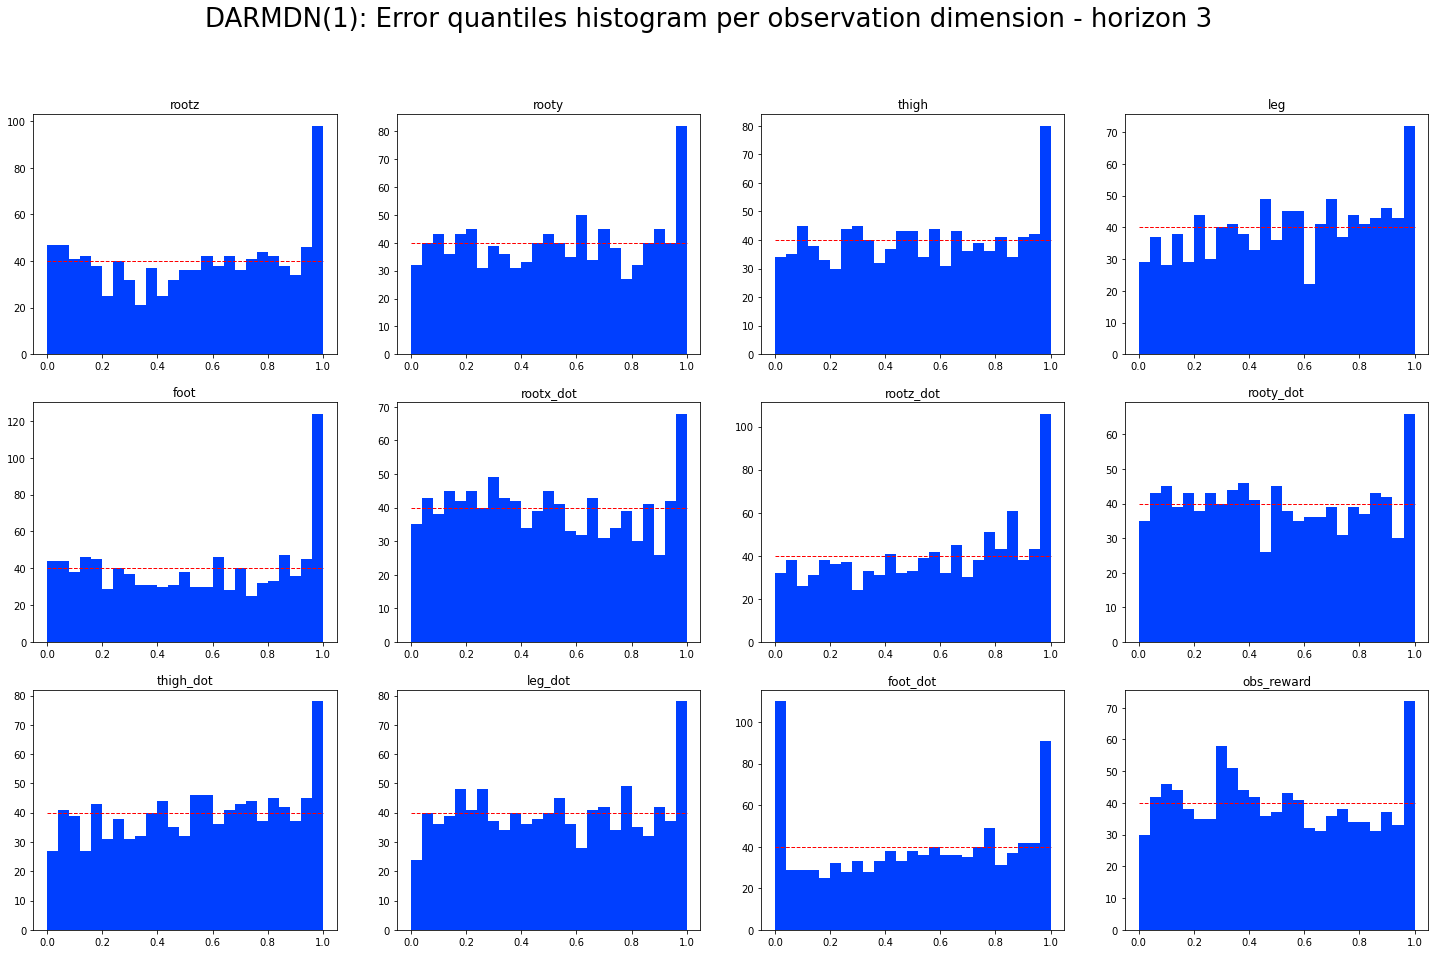

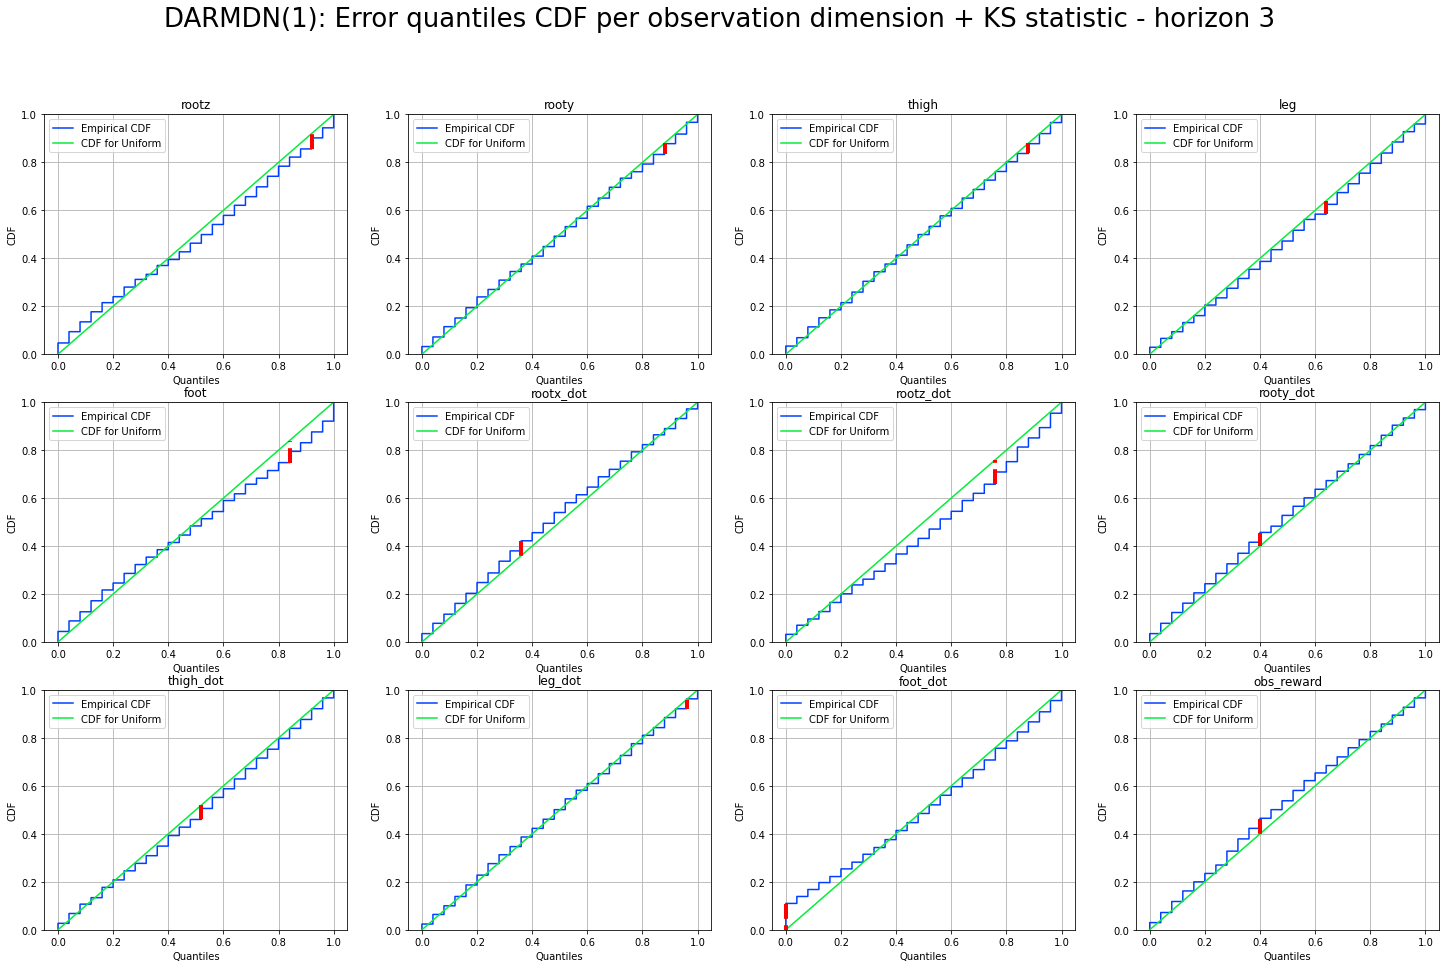

In [68]:
env = 'hopper-v2'

data_label = 'd4rl_medium'
n_traces = 25

submission = 'darmdn_single_d4rl_medium_50k_500k_hyperopt'
label = 'DARMDN(1)'

horizon = 3

ks_cdf_all(env=env, data_label=data_label, n_traces=n_traces, submission=submission, horizon=horizon, label=label)

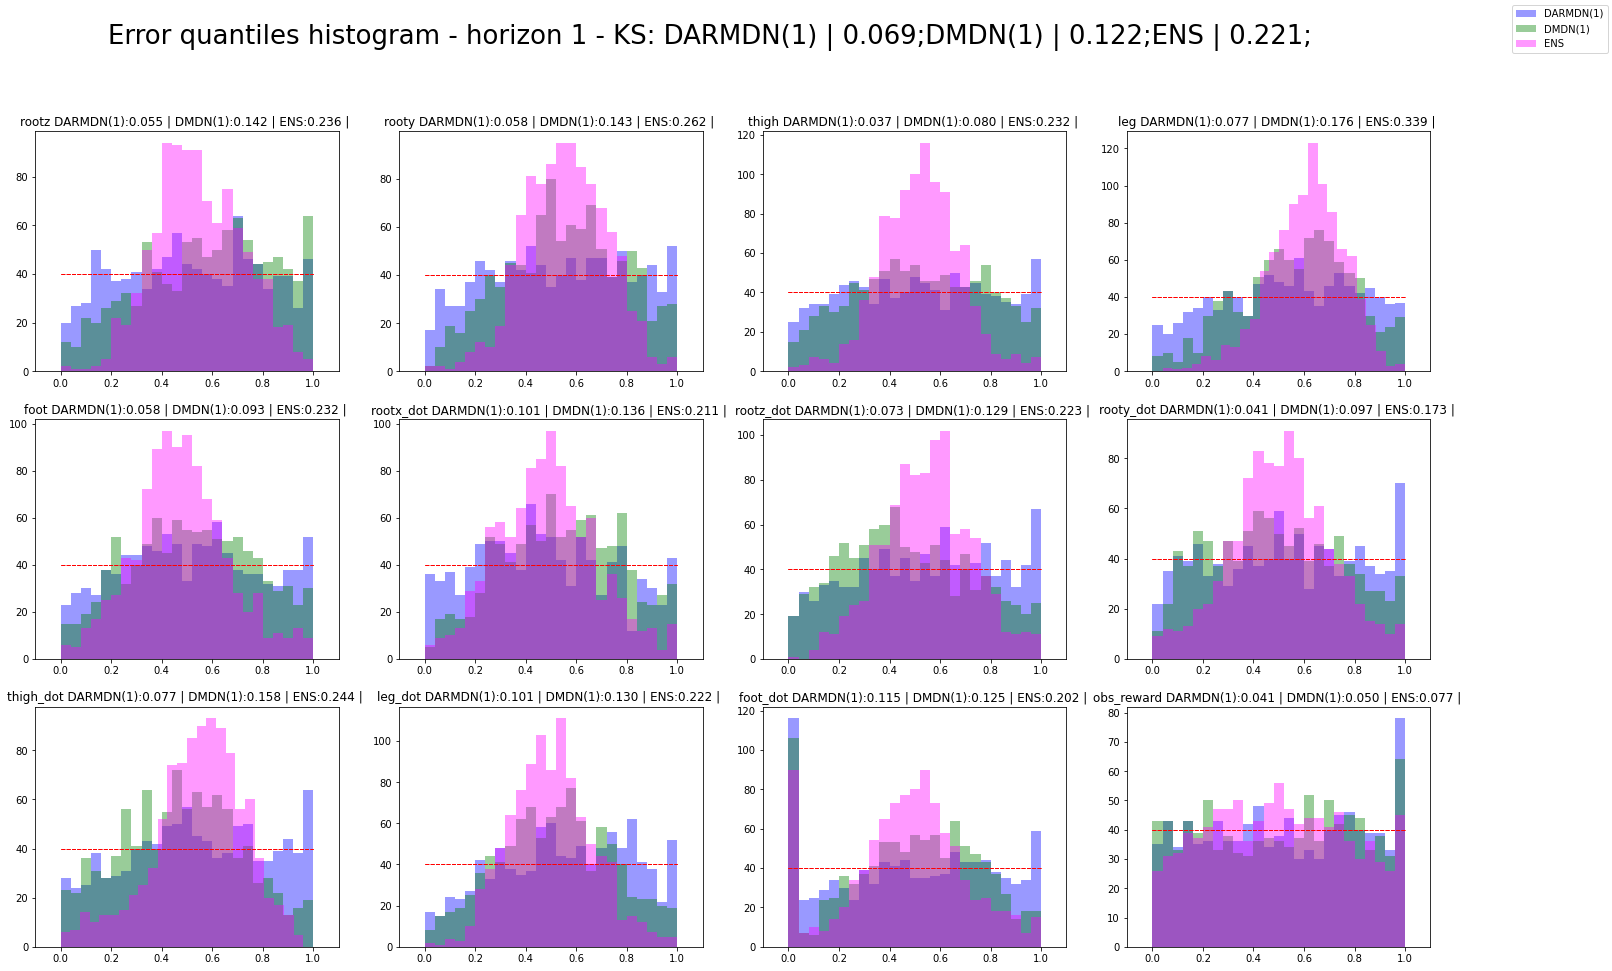

In [121]:
env = 'hopper-v2'

data_label = 'd4rl_medium'
n_traces = 25

submissions = ['darmdn_single_d4rl_medium_50k_500k_hyperopt', 'dmdn_single_d4rl_medium_50k_500k_hyperopt', 'dmdn_single_ensemble_vectorized']
labels = ['DARMDN(1)', 'DMDN(1)', 'ENS']
# submissions = ['darmdn_single_d4rl_medium_50k_500k_hyperopt', 'dmdn_single_d4rl_medium_50k_500k_hyperopt']
# labels = ['DARMDN(1)', 'DMDN(1)']
colors = ['blue', 'green', 'fuchsia']

horizon = 1

# metadata
metadata_path = os.path.join('data', 'metadata.json')
metadata = get_metadata_dictionary(metadata_path)

n_dim = 12
n_bins = 25
global_ks = []

#Visualize results
fig=plt.figure(figsize=(25,15))
for i in range(12):
    a=fig.add_subplot(3,4,i+1)
    feature = metadata['observation'][i] 
    subtitle = feature +' '
    for idx, submission in enumerate(submissions):
        file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'ks_quantiles_df.csv')
        ks_quantiles = pd.read_csv(file_path)

        quantiles = ks_quantiles[feature].to_numpy()
        quantiles = quantiles.reshape((FUTURE_LENGTH, N_SAMPLES))[horizon-1, :]
        x = quantiles
        n = len(quantiles)
        
        # Compute ks 
        ks = np.max(np.abs(quantiles - (np.arange(len(quantiles))/len(quantiles)))) 
        
        # plt.xlabel('quantiles')
        # plt.ylabel('count')
        if i==0:
            plt.hist(x, bins=n_bins, alpha=.4, color=colors[idx], label=labels[idx])
            global_ks.append(ks)
        else:
            plt.hist(x, bins=n_bins, alpha=.4, color=colors[idx])
            global_ks[idx] += ks
        plt.hlines(n/n_bins, 0, 1, color='r', linestyle='dashed', lw=1)  
        subtitle += f'{labels[idx]}:{ks:.3f} | '
    a.set_title(subtitle)
    a.set_xlim(-0.1, 1.1)
    
global_ks = np.array(global_ks)/12

title = f'Error quantiles histogram - horizon {horizon} - KS: '
for i in range(len(labels)):
    title += f'{labels[i]} | {global_ks[i]:.3f};'
fig.suptitle(title, fontsize=26)
fig.legend()
plt.show()

# Variance across traces

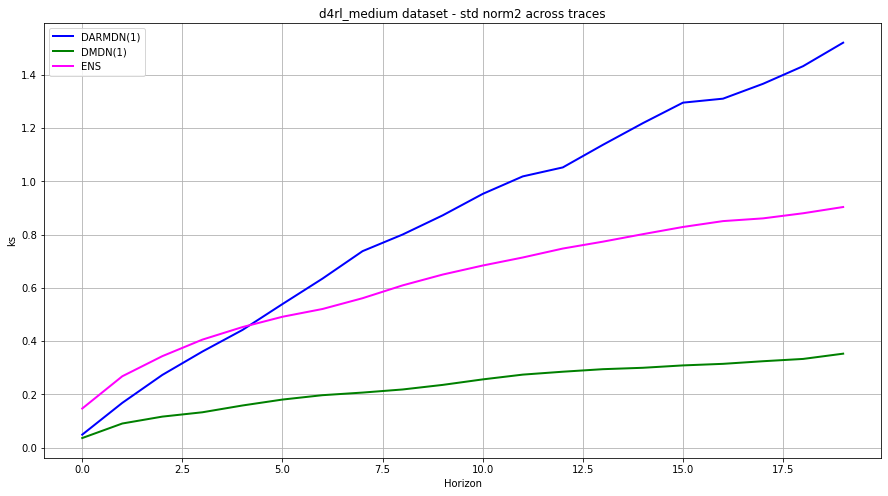

In [97]:
env = 'hopper-v2'

data_label = 'd4rl_medium'
n_traces = 25

submissions = ['darmdn_single_d4rl_medium_50k_500k_hyperopt', 'dmdn_single_d4rl_medium_50k_500k_hyperopt', 'dmdn_single_ensemble_vectorized']
labels = ['DARMDN(1)', 'DMDN(1)', 'ENS']
# submissions = ['darmdn_single_d4rl_medium_50k_500k_hyperopt', 'dmdn_single_d4rl_medium_50k_500k_hyperopt']
# labels = ['DARMDN(1)', 'DMDN(1)']
colors = ['blue', 'green', 'fuchsia']

fig, axes = plt.subplots(1, figsize=(15, 8))

for i, submission in enumerate(submissions):
    # future_board = future_leaderboard(submission, data_label, n_folds, future_length)
    file_path = os.path.join('submissions', submission, 'training_output', data_label, f'fold_0', 'long_horizon_metrics', 'stds_df.csv')
    stds_df = pd.read_csv(file_path)

    axes.plot(np.linalg.norm(stds_df.to_numpy(), axis=1), label=labels[i], linewidth=2, color=colors[i])
    axes.set_ylabel(score_name)

    axes.legend()

axes.grid()

plt.xlabel('Horizon')
plt.title(f'{data_label} dataset - std norm2 across traces')
plt.show()